In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.linear_model import RidgeCV
import warnings
warnings.filterwarnings('ignore')

In [117]:
%run Feature_Creation.ipynb
%run Auxillary_Functions.ipynb

In [118]:
SPY = pd.read_csv(os.path.join(os.path.abspath(os.getcwd()),'data','largecap','SPY.csv'))

SPY_feat = create_features(SPY)

SPY_feat.head()

,Date,Open,High,Low,Close,Adj Close,Volume,1day_pct,2day_pct,3day_pct,...,current_hot_streak,current_cold_streak,prev_current_hot,prev_current_cold,current_hot_prev_cold,current_cold_prev_hot,7g(50&200),7l(50&200),7g50,7g200
1,2015-01-13,204.119995,205.479996,200.509995,202.080002,181.255432,214553300,-0.002813,-0.010624,-0.018553,...,0.0,1.0,0.0,-1.0,0.0,1.0,False,True,False,False
2,2015-01-14,199.649994,201.100006,198.570007,200.860001,180.161163,192991100,-0.006037,-0.008833,-0.016597,...,0.0,2.0,0.0,-2.0,0.0,2.0,False,True,False,False
3,2015-01-15,201.630005,202.009995,198.880005,199.020004,178.510773,176613900,-0.009161,-0.015142,-0.017912,...,0.0,3.0,0.0,-3.0,0.0,3.0,False,True,False,False
4,2015-01-16,198.770004,201.820007,198.550003,201.630005,180.851807,211879600,0.013114,0.003833,-0.002227,...,1.0,0.0,-1.0,3.0,-2.0,0.0,False,True,False,False
5,2015-01-20,202.399994,202.720001,200.169998,202.059998,181.237518,130991100,0.002133,0.015275,0.005974,...,2.0,0.0,-2.0,3.0,-1.0,0.0,False,True,False,False


In [119]:
SPY_feat[['1_day_target','1day_pct','target','prev_hot_streak']].iloc[1:10]

,1_day_target,1day_pct,target,prev_hot_streak
2,-1.650391,-0.006037,0.0,0.0
3,2.341034,-0.009161,1.0,0.0
4,0.385712,0.013114,1.0,0.0
5,0.914871,0.002133,1.0,0.0
6,2.708771,0.005048,1.0,0.0
7,-1.013550,0.014871,0.0,0.0
8,0.430557,-0.005483,1.0,4.0
9,-2.430740,0.002342,0.0,4.0
10,-2.332077,-0.013191,0.0,1.0


In [120]:
continuous = ['1day_pct', '2day_pct', '3day_pct', '4day_pct', '5day_pct', '7day_pct',
       'ewma_7', 'ewma_50', 'ewma_200', 'RSI', 'MACD','Volume','day_var','open_close','open_prev_close','high_close']
discrete = ['prev_hot_streak','prev_cold_streak', 'current_hot_streak', 'current_cold_streak','RSI_overbought','RSI_oversold',
            '7g(50&200)','7l(50&200)','7g50','7g200', 'prev_current_hot', 'prev_current_cold','current_hot_prev_cold','current_cold_prev_hot']

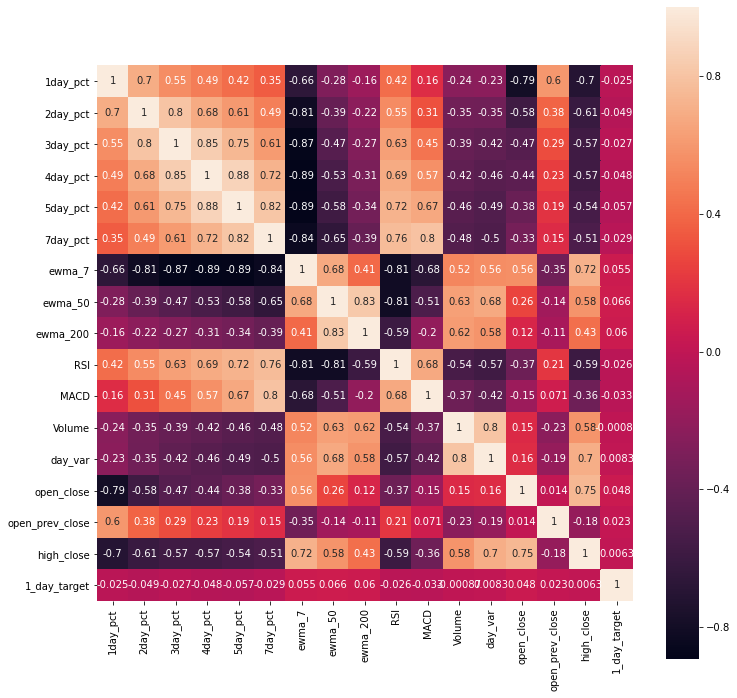

In [121]:
plt.figure(figsize=(12,12))
sns.heatmap(SPY_feat[['1day_pct', '2day_pct', '3day_pct', '4day_pct', '5day_pct', '7day_pct',
       'ewma_7', 'ewma_50', 'ewma_200', 'RSI', 'MACD','Volume','day_var','open_close','open_prev_close','high_close','1_day_target']].corr(),vmax=1.,square=True,annot=True)

## Normalizing Features

### At first we will only try continuous features

In [122]:
y = SPY_feat['1_day_target']
X = SPY_feat.drop(['Date','Adj Close','High','Low','Close','target'],axis=1)

continuous = ['1day_pct', '2day_pct', '3day_pct', '4day_pct', '5day_pct', '7day_pct',
       'ewma_7', 'ewma_50', 'ewma_200', 'RSI', 'MACD','Volume','day_var','open_close','open_prev_close','high_close']
#discrete = ['prev_hot_streak','prev_cold_streak', 'current_hot_streak', 'current_cold_streak','RSI_overbought','RSI_oversold',
#            '7g(50&200)','7l(50&200)','7g50','7g200', 'prev_current_hot', 'prev_current_cold','current_hot_prev_cold','current_cold_prev_hot']
scaler = StandardScaler()
X_cont = pd.DataFrame(scaler.fit_transform(X[continuous]),columns=continuous)

#X_disc = X[discrete]

X_cont.reset_index(drop=True,inplace=True)

#X_disc.reset_index(drop=True,inplace=True)

#X = pd.concat([X_cont,X_disc],axis=1)
X = X_cont

In [123]:
X_train, y_train, X_val, y_val, X_test, y_test = traintestvalsplit(X,y)

In [132]:
ridge = RidgeCV(alphas=np.logspace(-2,1,20)).fit(X_train, y_train)
#Predict on training data
pred = ridge.predict(X_train)
#Preddict on Test data
testpred = ridge.predict(X_test)
alpha = ridge.alpha_
print(alpha)    

log_err = [(np.abs((testpred-y_test)/y_test)).mean(),((testpred-y_test)/y_test).std(),
               np.sqrt(((testpred-y_test)**2).sum()/len(y_test))]
print('The rmse error in log predictions is',log_err[2])


10.0
The rmse error in log predictions is 2.192813576669105


#### alpha for Ridge automatically picks the largest value. Need to figure out what that means

In [133]:
y_hat_test = testpred > 0
y_test_bool = y_test > 0
print('precision score' ,precision_score(y_hat_test,y_test_bool))
print('recall score' ,recall_score(y_hat_test,y_test_bool))
print('accuracy score' ,accuracy_score(y_hat_test,y_test_bool))
print('f1 score' ,f1_score(y_hat_test,y_test_bool))

precision score 0.668918918918919
recall score 0.5823529411764706
accuracy score 0.52
f1 score 0.6226415094339623


## Now we will try discrete features with get_dummies

In [126]:
y = SPY_feat['1_day_target']
X = SPY_feat.drop(['Date','Adj Close','High','Low','Close','target'],axis=1)

#continuous = ['1day_pct', '2day_pct', '3day_pct', '4day_pct', '5day_pct', '7day_pct',
#       'ewma_7', 'ewma_50', 'ewma_200', 'RSI', 'MACD','Volume','day_var','open_close','open_prev_close','high_close']
discrete = ['prev_hot_streak','prev_cold_streak', 'current_hot_streak', 'current_cold_streak','RSI_overbought','RSI_oversold',
            '7g(50&200)','7l(50&200)','7g50','7g200', 'prev_current_hot', 'prev_current_cold','current_hot_prev_cold','current_cold_prev_hot']
#scaler = StandardScaler()
#X_cont = pd.DataFrame(scaler.fit_transform(X[continuous]),columns=continuous)

X_disc = X[discrete]
X_disc = pd.get_dummies(X_disc,columns=discrete)
#X_cont.reset_index(drop=True,inplace=True)

X_disc.reset_index(drop=True,inplace=True)

#X = pd.concat([X_cont,X_disc],axis=1)
X = X_disc

In [127]:
X_train, y_train, X_val, y_val, X_test, y_test = traintestvalsplit(X,y)

10.0
The rmse error in log predictions is 2.192813576669105


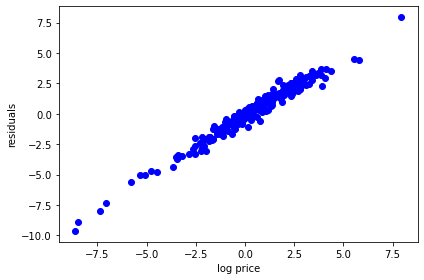

In [128]:
ridge = RidgeCV(alphas=np.logspace(-2,1,20)).fit(X_train, y_train)
#Predict on training data
pred = ridge.predict(X_train)
#Preddict on Test data
testpred = ridge.predict(X_test)
alpha = ridge.alpha_
print(alpha)    

log_err = [(np.abs((testpred-y_test)/y_test)).mean(),((testpred-y_test)/y_test).std(),
               np.sqrt(((testpred-y_test)**2).sum()/len(y_test))]
print('The rmse error in log predictions is',log_err[2])
plt.figure()
plt.plot(y_test, y_test-testpred,'bo');
plt.ylabel('residuals')
plt.xlabel('log price')
plt.tight_layout()
plt.savefig('residuals_final_model.png')

In [129]:
y_hat_test = testpred > 0
y_test_bool = y_test > 0
print('precision score' ,precision_score(y_hat_test,y_test_bool))
print('recall score' ,recall_score(y_hat_test,y_test_bool))
print('accuracy score' ,accuracy_score(y_hat_test,y_test_bool))
print('f1 score' ,f1_score(y_hat_test,y_test_bool))

precision score 0.668918918918919
recall score 0.5823529411764706
accuracy score 0.52
f1 score 0.6226415094339623


In [138]:
y = SPY_feat['1_day_target']
X = SPY_feat.drop(['Date','Adj Close','High','Low','Close','target'],axis=1)

continuous = ['1day_pct', '2day_pct', '3day_pct', '4day_pct', '5day_pct', '7day_pct',
       'ewma_7', 'ewma_50', 'ewma_200', 'RSI', 'MACD','Volume','day_var','open_close','open_prev_close','high_close']
discrete = ['prev_hot_streak','prev_cold_streak', 'current_hot_streak', 'current_cold_streak','RSI_overbought','RSI_oversold',
            '7g(50&200)','7l(50&200)','7g50','7g200', 'prev_current_hot', 'prev_current_cold','current_hot_prev_cold','current_cold_prev_hot']
scaler = StandardScaler()
X_cont = pd.DataFrame(scaler.fit_transform(X[continuous]),columns=continuous)

X_disc = X[discrete]
X_disc = pd.get_dummies(X_disc,columns=discrete)
X_cont.reset_index(drop=True,inplace=True)

X_disc.reset_index(drop=True,inplace=True)

X = pd.concat([X_cont,X_disc],axis=1)


10.0
The rmse error in log predictions is 2.192813576669105


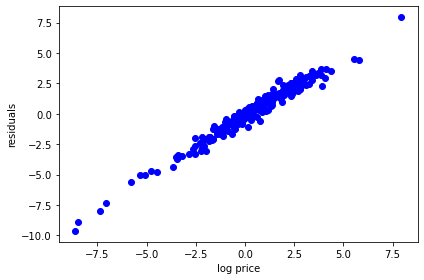

In [140]:
ridge = RidgeCV(alphas=np.logspace(-2,1,20)).fit(X_train, y_train)
#Predict on training data
pred = ridge.predict(X_train)
#Preddict on Test data
testpred = ridge.predict(X_test)
alpha = ridge.alpha_
print(alpha)    

log_err = [(np.abs((testpred-y_test)/y_test)).mean(),((testpred-y_test)/y_test).std(),
               np.sqrt(((testpred-y_test)**2).sum()/len(y_test))]
print('The rmse error in log predictions is',log_err[2])
plt.figure()
plt.plot(y_test, y_test-testpred,'bo');
plt.ylabel('residuals')
plt.xlabel('log price')
plt.tight_layout()
plt.savefig('residuals_final_model.png')

In [141]:
y_hat_test = testpred > 0
y_test_bool = y_test > 0
print('precision score' ,precision_score(y_hat_test,y_test_bool))
print('recall score' ,recall_score(y_hat_test,y_test_bool))
print('accuracy score' ,accuracy_score(y_hat_test,y_test_bool))
print('f1 score' ,f1_score(y_hat_test,y_test_bool))

precision score 0.668918918918919
recall score 0.5823529411764706
accuracy score 0.52
f1 score 0.6226415094339623


In [142]:
y_hat_test

array([False, False, False, False, False, False,  True, False,  True,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False,  True, False,
        True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True, False,  True,
       False,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True, False, False,
        True, False,  True, False, False,  True,  True, False,  True,
       False, False,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True, False, False,  True,  True,
        True,  True,  True, False, False,  True, False, False, False,
        True, False,

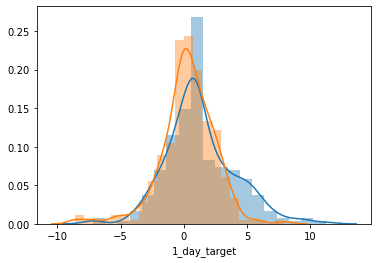

In [148]:
sns.distplot(7*testpred)
sns.distplot(y_test)